##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train and serve a TensorFlow model with TensorFlow Serving

**Warning: This notebook is designed to be run in a Google Colab only**.  It installs packages on the system and requires root access.  If you want to run it in a local Jupyter notebook, please proceed with caution.

Note: You can run this example right now in a Jupyter-style notebook, no setup required!  Just click "Run in Google Colab"

<div class="devsite-table-wrapper"><table class="tfo-notebook-buttons" align="left">
<tr><td><a target="_blank" href="https://www.tensorflow.org/tfx/tutorials/serving/rest_simple">
<img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a></td>
<td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb">
<img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a></td>
<td><a target="_blank" href="https://github.com/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb">
<img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a></td>
<td><a href="https://storage.googleapis.com/tensorflow_docs/tfx/docs/tutorials/serving/rest_simple.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td>
</tr></table></div>

This guide trains a neural network model to classify [images of clothing, like sneakers and shirts](https://github.com/zalandoresearch/fashion-mnist), saves the trained model, and then serves it with [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).  The focus is on TensorFlow Serving, rather than the modeling and training in TensorFlow, so for a complete example which focuses on the modeling and training see the [Basic Classification example](https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/keras/basic_classification.ipynb).

This guide uses [tf.keras](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/keras.ipynb), a high-level API to build and train models in TensorFlow.

In [2]:
import sys

# Confirm that we're using Python 3
assert sys.version_info.major == 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

In [3]:
# TensorFlow and tf.keras
print("Installing dependencies for Colab environment")
!pip install -Uq grpcio==1.26.0

import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

print('TensorFlow version: {}'.format(tf.__version__))

Installing dependencies for Colab environment


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\Jaime GG-B\AppData\Local\Programs\Python\Python39\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Jaime GG-B\\AppData\\Local\\Temp\\pip-install-97r6szst\\grpcio_23598bb905dc4de1a7f3917139dad1c9\\setup.py'"'"'; __file__='"'"'C:\\Users\\Jaime GG-B\\AppData\\Local\\Temp\\pip-install-97r6szst\\grpcio_23598bb905dc4de1a7f3917139dad1c9\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Jaime GG-B\AppData\Local\Temp\pip-wheel-flsdmbzw'
       cwd: C:\Users\Jaime GG-B\AppData\Local\Temp\pip-install-97r6szst\grpcio_23598bb905dc4de1a7f3917139dad1c9\
  Complete output (67 lines):
  Found cython-generated files...
  running bdist_wheel
  runni

TensorFlow version: 2.8.0


## Create your model

### Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. You can access the Fashion MNIST directly from TensorFlow, just import and load the data.

Note: Although these are really images, they are loaded as NumPy arrays and not binary image objects.

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


### Train and evaluate your model

Let's use the simplest possible CNN, since we're not focused on the modeling part.

In [5]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, name='Dense')
])
model.summary()

testing = False
epochs = 5

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 13, 13, 8)         80        
                                                                 
 flatten (Flatten)           (None, 1352)              0         
                                                                 
 Dense (Dense)               (None, 10)                13530     
                                                                 
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5384 - sparse_categorical_accuracy: 0.8112
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3866 - sparse_categorical_accuracy: 0.8645
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0

## Save your model

To load our trained model into TensorFlow Serving we first need to save it in [SavedModel](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/saved_model) format.  This will create a protobuf file in a well-defined directory hierarchy, and will include a version number.  [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving) allows us to select which version of a model, or "servable" we want to use when we make inference requests.  Each version will be exported to a different sub-directory under the given path.

In [6]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile
import os

# MODEL_DIR = tempfile.gettempdir()
MODEL_DIR = os.getcwd()

version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = c:\Users\Jaime GG-B\TensorflowServingExample\1



INFO:tensorflow:Assets written to: c:\Users\Jaime GG-B\TensorflowServingExample\1\assets


INFO:tensorflow:Assets written to: c:\Users\Jaime GG-B\TensorflowServingExample\1\assets



Saved model:


'ls' is not recognized as an internal or external command,
operable program or batch file.


## Examine your saved model

We'll use the command line utility `saved_model_cli` to look at the [MetaGraphDefs](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/MetaGraphDef) (the models) and [SignatureDefs](https://www.tensorflow.org/tfx/serving/signature_defs) (the methods you can call) in our SavedModel.  See [this discussion of the SavedModel CLI](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/saved_model.md#cli-to-inspect-and-execute-savedmodel) in the TensorFlow Guide.

In [7]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Dense'] tensor_info:
        dtype: DT_FLOAT

2022-09-30 17:44:46.417416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-09-30 17:44:46.417997: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          Conv1_input: TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='Conv1_input')
        Argument #2
          DType: bool
          Value: False
        Argument #3
          DType: NoneType
          Value: None
    Option #2
      Callable with:
        Argument #1
          inputs: TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='inputs')
        Argument #2
          DType: bool
          Value: False
        Argument #3
          DType: NoneType
          Value: None
    Option #3
      Callable with:
        Argument #1
          Conv1_input: TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='Conv1_input')
        Argument #2
          DType: bool
          Value: True
        Argument #3
          DType: NoneType
          Value: No

That tells us a lot about our model!  In this case we just trained our model, so we already know the inputs and outputs, but if we didn't this would be important information.  It doesn't tell us everything, like the fact that this is grayscale image data for example, but it's a great start.

## Serve your model with TensorFlow Serving

**Warning: If you are running this NOT on a Google Colab,** following cells
will install packages on the system with root access. If you want to run it in
a local Jupyter notebook, please proceed with caution.

### Add TensorFlow Serving distribution URI as a package source:

We're preparing to install TensorFlow Serving using [Aptitude](https://wiki.debian.org/Aptitude) since this Colab runs in a Debian environment.  We'll add the `tensorflow-model-server` package to the list of packages that Aptitude knows about.  Note that we're running as root.

Note: This example is running TensorFlow Serving natively, but [you can also run it in a Docker container](https://www.tensorflow.org/tfx/serving/docker), which is one of the easiest ways to get started using TensorFlow Serving.

In [8]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [9]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

'sudo' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.


### Install TensorFlow Serving

This is all you need - one command line!

In [10]:
!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

'sudo' is not recognized as an internal or external command,
operable program or batch file.


### Start running TensorFlow Serving

This is where we start running TensorFlow Serving and load our model.  After it loads we can start making inference requests using REST.  There are some important parameters:

* `rest_api_port`: The port that you'll use for REST requests.
* `model_name`: You'll use this in the URL of REST requests.  It can be anything.
* `model_base_path`: This is the path to the directory where you've saved your model.


In [11]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [12]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


In [13]:
!tail server.log

'tail' is not recognized as an internal or external command,
operable program or batch file.


## Make a request to your model in TensorFlow Serving

First, let's take a look at a random example from our test data.

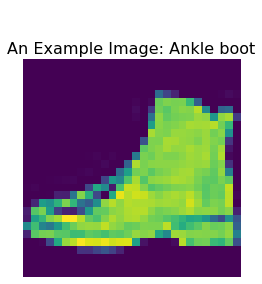

In [14]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

Ok, that looks interesting.  How hard is that for you to recognize? Now let's create the JSON object for a batch of  three inference requests, and see how well our model recognizes things:

In [15]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


### Make REST requests

#### Newest version of the servable

We'll send a predict request as a POST to our server's REST endpoint, and pass it three examples.  We'll ask our server to give us the latest version of our servable by not specifying a particular version.

In [16]:
# docs_infra: no_execute
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[0]], test_labels[0]))

You should consider upgrading via the 'C:\Users\Jaime GG-B\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


ConnectionError: HTTPConnectionPool(host='localhost', port=8501): Max retries exceeded with url: /v1/models/fashion_model:predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002350654FCA0>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

#### A particular version of the servable

Now let's specify a particular version of our servable.  Since we only have one, let's select version 1.  We'll also look at all three results.

In [ ]:
# docs_infra: no_execute
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,3):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[i]], test_labels[i]))